# Algorithm Comparison for Behavioral Cloning

This notebook provides a comparison of different neural network architectures for behavioral cloning in the risky navigation environment.

**Algorithms Evaluated:**
- **Linear**: Simple linear regression baseline
- **AutoEncoder**: Neural network encoder-decoder architecture  
- **Bayesian**: Bayesian neural network with uncertainty quantification
- **Transformer**: Self-attention based model
- **VAE**: Variational AutoEncoder with probabilistic latent representations

**Workflow:**
1. **Data Collection**: Load expert demonstrations from optimal visibility graph policy
2. **Model Training**: Train each algorithm with simple, transparent training loop
3. **Evaluation**: Test models in environment and compare performance
4. **Analysis**: Visualize results and compare metrics

This simplified approach prioritizes debuggability and clarity over automated hyperparameter optimization.

## Import Required Libraries

In [1]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision torchaudio gymnasium tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import os
import warnings
from tqdm import tqdm
from datetime import datetime
import random

print(os.path.abspath('.'))

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')


/


In [3]:
import sys
sys.path.append('/risky_navigation')

from src.env.continuous_nav_env import ContinuousNavigationEnv
from src.algorithms.AutoEncoder.agent import AutoEncoderAgent
from src.algorithms.Bayesian.agent import BayesianAgent
from src.algorithms.Transformer.agent import TransformerAgent
from src.algorithms.Linear.agent import LinearAgent
from src.algorithms.VAE.agent import VAEAgent
from src.utils.file_management import save_pickle, load_pickle

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


All libraries imported successfully!
PyTorch version: 2.8.0+cu128
Device available: CUDA


## Config

In [ ]:
CONFIG = {
    'num_episodes': 1000,
    'max_steps': 200,
    'batch_size': 256,
    'num_epochs': 150,  # Increased for early stopping
    'val_ratio': 0.2,
    'num_test_episodes': 50,
    'lr': 1e-3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

MODEL_CONFIGS = {
    'AutoEncoder': {'latent_dim': 32, 'hidden_dims': [128, 64], 'dropout': 0.1},
    'Linear': {},
    'Transformer': {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.1},
    'Bayesian': {'hidden_dim': 128, 'prior_std': 1.0},
    'VAE': {'latent_dim': 32, 'hidden_dim': 128, 'beta': 1.0}
}

print(f"Using device: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Max epochs: {CONFIG['num_epochs']} (with early stopping)")


Using device: cuda
Batch size: 256
Training epochs: 100


In [5]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')
    torch.cuda.empty_cache()
    print("GPU optimizations enabled for RTX 4090")
    print(f"Batch size: {CONFIG['batch_size']}")
else:
    print("WARNING: CUDA not available. Running on CPU will be very slow!")


GPU optimizations enabled for RTX 4090
Batch size: 256


## Training Function

In [ ]:
def train_agent_simple(agent, train_states, train_expert_actions, train_goals,
                       val_states, val_expert_actions, val_goals, 
                       num_epochs=100, batch_size=256, device='cpu', verbose=True):
    """Training loop with early stopping, LR scheduling, and gradient clipping."""
    train_losses = []
    val_losses = []
    n_train = len(train_states)
    
    # Early stopping setup
    best_val_loss = float('inf')
    patience = 10
    epochs_no_improve = 0
    best_model_state = None
    
    # Learning rate scheduler
    if hasattr(agent, 'optimizer'):
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            agent.optimizer, mode='min', factor=0.5, patience=5, verbose=False
        )
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        indices = np.random.permutation(n_train)
        
        for start_idx in range(0, n_train, batch_size):
            end_idx = min(start_idx + batch_size, n_train)
            batch_indices = indices[start_idx:end_idx]
            
            batch_states = torch.tensor(train_states[batch_indices], dtype=torch.float32, device=device)
            batch_actions = torch.tensor(train_expert_actions[batch_indices], dtype=torch.float32, device=device)
            
            loss = agent.train_step(batch_states, None, None, batch_actions)
            
            # Gradient clipping
            if hasattr(agent, 'optimizer'):
                if hasattr(agent, 'model'):
                    torch.nn.utils.clip_grad_norm_(agent.model.parameters(), 1.0)
                elif hasattr(agent, 'encoder'):
                    torch.nn.utils.clip_grad_norm_(
                        list(agent.encoder.parameters()) + list(agent.decoder.parameters()), 1.0
                    )
            
            epoch_loss += loss
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        val_states_t = torch.tensor(val_states, dtype=torch.float32, device=device)
        val_actions_t = torch.tensor(val_expert_actions, dtype=torch.float32, device=device)
        
        with torch.no_grad():
            if hasattr(agent, 'model'):
                agent.model.eval()
                predictions = agent.model(val_states_t)
            elif hasattr(agent, 'encoder'):
                agent.encoder.eval()
                agent.decoder.eval()
                mu, _ = agent.encoder(val_states_t)
                predictions = agent.decoder(mu)
            else:
                predictions = agent.predict_action(val_states_t, None)
            
            val_loss = torch.nn.functional.mse_loss(predictions, val_actions_t).item()
        
        val_losses.append(val_loss)
        
        # LR scheduler
        if hasattr(agent, 'optimizer'):
            scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save best model
            if hasattr(agent, 'model'):
                best_model_state = agent.model.state_dict().copy()
            elif hasattr(agent, 'encoder'):
                best_model_state = {
                    'encoder': agent.encoder.state_dict().copy(),
                    'decoder': agent.decoder.state_dict().copy()
                }
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stop at epoch {epoch}. Best val: {best_val_loss:.6f}")
                # Restore best
                if best_model_state:
                    if hasattr(agent, 'model'):
                        agent.model.load_state_dict(best_model_state)
                    elif hasattr(agent, 'encoder'):
                        agent.encoder.load_state_dict(best_model_state['encoder'])
                        agent.decoder.load_state_dict(best_model_state['decoder'])
                break
        
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:3d}/{num_epochs}: Train = {avg_train_loss:.6f}, Val = {val_loss:.6f}")
            
            if np.isnan(avg_train_loss) or np.isnan(val_loss):
                print(f"WARNING: NaN at epoch {epoch}!")
                break
    
    return train_losses, val_losses

print("Training function with early stopping, LR scheduling, and gradient clipping ready!")


Training function defined!


## Data Collection and Preparation

In [7]:
def collect_rl_experience(env, num_episodes=100, max_steps=200):
    """Collect RL training data using optimal policy with proper goal stopping."""
    data = []
    successful_episodes = 0
    
    for ep in tqdm(range(num_episodes), desc='Collecting RL experience'):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        
        for t in range(max_steps):
            current_pos = state[:2]
            current_theta = state[2]
            current_velocity = state[3]  # Current velocity from state
            dist_to_goal = np.linalg.norm(current_pos - goal)
            
            # Calculate desired heading towards goal
            direction = goal - current_pos
            desired_theta = np.arctan2(direction[1], direction[0])
            angle_diff = desired_theta - current_theta
            angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
            steering = np.clip(angle_diff, env.action_space.low[1], env.action_space.high[1])
            
            # IMPROVED THROTTLE CONTROL: Gradual deceleration near goal
            # Goal requires: distance <= 0.5 AND velocity < 0.1
            if dist_to_goal < env.goal_radius * 3:  # Within 1.5 units of goal
                # Proportional throttle based on distance
                # At distance 1.5: throttle = 0.3 * max
                # At distance 0.5: throttle = 0.1 * max  
                # At distance 0.0: throttle = 0.0
                throttle_factor = max(0.0, min(1.0, (dist_to_goal / (env.goal_radius * 3)) * 0.3))
                throttle = env.action_space.high[0] * throttle_factor
            else:
                # Full speed when far from goal
                throttle = env.action_space.high[0]
            
            # If very close and moving slowly, stop completely
            if dist_to_goal < env.goal_radius and current_velocity < env.goal_velocity * 1.5:
                throttle = 0.0
                steering = 0.0
            
            action = np.array([throttle, steering])
            action = np.clip(action, env.action_space.low, env.action_space.high)
            
            next_state, reward, done, info = env.step(action)
            
            data.append({
                'state': state.copy(),
                'action': action.copy(),
                'reward': reward,
                'next_state': next_state.copy(),
                'done': done,
                'goal': goal.copy()
            })
            
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    successful_episodes += 1
                break
    
    print(f"Collected {len(data)} transitions from {num_episodes} episodes")
    print(f"Success rate: {successful_episodes/num_episodes:.2%}")
    
    return data

print("Data collection function defined!")
print("IMPROVED: Gradual deceleration with proportional throttle control near goal")


Data collection function defined!
IMPROVED: Gradual deceleration with proportional throttle control near goal


In [8]:
# Load or collect data
dataset_path = 'rl_experience_dataset.pickle'

if os.path.exists(dataset_path):
    print(f"Deleting old dataset (0% success rate)...")
    os.remove(dataset_path)

print(f"Collecting new dataset with fixed expert policy...")
env_collect = ContinuousNavigationEnv()
data = collect_rl_experience(env_collect, num_episodes=CONFIG['num_episodes'], max_steps=CONFIG['max_steps'])
save_pickle(data, dataset_path)
print(f"✓ Saved dataset to {dataset_path}")

# Extract states, actions, and goals from data
states = np.array([d['state'] for d in data])
actions = np.array([d['action'] for d in data])
next_states = np.array([d['next_state'] for d in data])
rewards = np.array([d['reward'] for d in data])
dones = np.array([d['done'] for d in data])
goals = np.array([d['goal'] for d in data])

print(f"\nData extracted:")
print(f"  States shape: {states.shape}")
print(f"  Actions shape: {actions.shape}")
print(f"  Goals shape: {goals.shape}")
print(f"  Rewards shape: {rewards.shape}")


Deleting old dataset (0% success rate)...


Collected 185440 transitions from 1000 episodes
Success rate: 99.90%
✓ Saved dataset to rl_experience_dataset.pickle
✓ Saved dataset to rl_experience_dataset.pickle

Data extracted:
  States shape: (185440, 8)
  Actions shape: (185440, 2)
  Goals shape: (185440, 2)
  Rewards shape: (185440,)

Data extracted:
  States shape: (185440, 8)
  Actions shape: (185440, 2)
  Goals shape: (185440, 2)
  Rewards shape: (185440,)


In [9]:
# Diagnostic: Check environment goal requirements
env_test = ContinuousNavigationEnv()
print("Environment Goal Requirements:")
print(f"  Goal position: {env_test.goal}")
print(f"  Goal radius: {env_test.goal_radius}")
print(f"  Goal velocity threshold: {env_test.goal_velocity}")
print(f"  Max throttle: {env_test.max_throttle}")
print(f"  Max steps: {env_test.max_steps}")
print(f"\nTo reach goal, agent must:")
print(f"  1. Be within {env_test.goal_radius} units of {env_test.goal}")
print(f"  2. Have velocity < {env_test.goal_velocity}")
print(f"\nSlowing strategy:")
print(f"  - Full throttle when distance > {env_test.goal_radius * 3:.2f}")
print(f"  - Gradual deceleration when distance < {env_test.goal_radius * 3:.2f}")
print(f"  - Stop when distance < {env_test.goal_radius} and velocity < {env_test.goal_velocity * 1.5}")


Environment Goal Requirements:
  Goal position: [5. 5.]
  Goal radius: 0.5
  Goal velocity threshold: 0.1
  Max throttle: 2.0
  Max steps: 1000

To reach goal, agent must:
  1. Be within 0.5 units of [5. 5.]
  2. Have velocity < 0.1

Slowing strategy:
  - Full throttle when distance > 1.50
  - Gradual deceleration when distance < 1.50
  - Stop when distance < 0.5 and velocity < 0.15000000000000002


In [10]:
# Define dimensions from the collected data
STATE_DIM = states.shape[1]
ACTION_DIM = actions.shape[1]
GOAL_DIM = goals.shape[1]

print(f"Data dimensions:")
print(f"  STATE_DIM = {STATE_DIM}")
print(f"  ACTION_DIM = {ACTION_DIM}")
print(f"  GOAL_DIM = {GOAL_DIM}")
print(f"  Total samples = {len(states)}")

Data dimensions:
  STATE_DIM = 8
  ACTION_DIM = 2
  GOAL_DIM = 2
  Total samples = 185440


In [11]:
# Initialize environment for evaluation
env = ContinuousNavigationEnv()
print(f"Environment initialized: {env}")
print(f"  State space: {env.observation_space.shape}")
print(f"  Action space: {env.action_space.shape}")

Environment initialized: <ContinuousNavigationEnv instance>
  State space: (8,)
  Action space: (2,)


## Train All Algorithms

In [12]:
print("="*60)
print("TRAINING ALL ALGORITHMS")
print("="*60)

# Split data
n_samples = len(states)
n_train = int(n_samples * (1 - CONFIG['val_ratio']))
indices = np.random.permutation(n_samples)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

train_states = states[train_indices]
train_actions = actions[train_indices]
train_goals = goals[train_indices]

val_states = states[val_indices]
val_actions = actions[val_indices]
val_goals = goals[val_indices]

print(f"Data split: {len(train_states)} train, {len(val_states)} val\n")

all_results = {}

algorithms_to_train = {
    'Linear': (LinearAgent, {}),
    'AutoEncoder': (AutoEncoderAgent, MODEL_CONFIGS['AutoEncoder']),
    'Transformer': (TransformerAgent, MODEL_CONFIGS['Transformer']),
    'Bayesian': (BayesianAgent, MODEL_CONFIGS['Bayesian']),
    'VAE': (VAEAgent, MODEL_CONFIGS['VAE'])
}

for algo_name, (AgentClass, model_config) in algorithms_to_train.items():
    print(f"\n{'='*60}")
    print(f"Training {algo_name}")
    print(f"{'='*60}")
    
    agent = AgentClass(
        state_dim=STATE_DIM,
        action_dim=ACTION_DIM,
        lr=CONFIG['lr'],
        device=CONFIG['device'],
        **model_config
    )
    
    start_time = time.time()
    train_losses, val_losses = train_agent_simple(
        agent, 
        train_states, train_actions, train_goals,
        val_states, val_actions, val_goals,
        num_epochs=CONFIG['num_epochs'],
        batch_size=CONFIG['batch_size'],
        device=CONFIG['device'],
        verbose=True
    )
    train_time = time.time() - start_time
    
    all_results[algo_name] = {
        'agent': agent,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_time': train_time
    }
    
    print(f"\n{algo_name} Complete! Time: {train_time:.2f}s")
    print(f"Final train loss: {train_losses[-1]:.6f}, Val loss: {val_losses[-1]:.6f}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("TRAINING COMPLETE!")
print(f"{'='*60}")


TRAINING ALL ALGORITHMS
Data split: 148352 train, 37088 val


Training Linear
Epoch   0/100: Train Loss = 0.294860, Val Loss = 0.029223
Epoch   0/100: Train Loss = 0.294860, Val Loss = 0.029223
Epoch  10/100: Train Loss = 0.021296, Val Loss = 0.020975
Epoch  10/100: Train Loss = 0.021296, Val Loss = 0.020975
Epoch  20/100: Train Loss = 0.021312, Val Loss = 0.020983
Epoch  20/100: Train Loss = 0.021312, Val Loss = 0.020983
Epoch  30/100: Train Loss = 0.021302, Val Loss = 0.020953
Epoch  30/100: Train Loss = 0.021302, Val Loss = 0.020953
Epoch  40/100: Train Loss = 0.021311, Val Loss = 0.021011
Epoch  40/100: Train Loss = 0.021311, Val Loss = 0.021011
Epoch  50/100: Train Loss = 0.021297, Val Loss = 0.021195
Epoch  50/100: Train Loss = 0.021297, Val Loss = 0.021195
Epoch  60/100: Train Loss = 0.021298, Val Loss = 0.021008
Epoch  60/100: Train Loss = 0.021298, Val Loss = 0.021008
Epoch  70/100: Train Loss = 0.021325, Val Loss = 0.021032
Epoch  70/100: Train Loss = 0.021325, Val Loss = 0.0

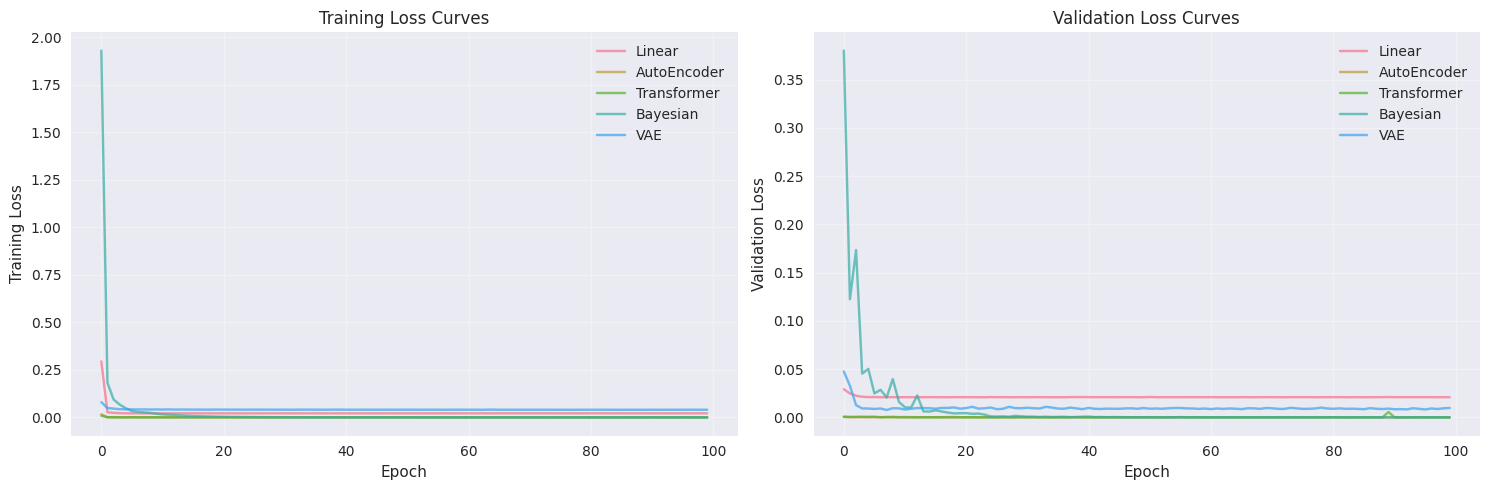


Final Loss Summary:
Algorithm       Train Loss      Val Loss        Train Time (s) 
------------------------------------------------------------
Linear          0.021313        0.020967        19.40          
AutoEncoder     0.000086        0.000063        39.30          
Transformer     0.000196        0.000130        98.44          
Bayesian        0.000111        0.000072        49.14          
VAE             0.040298        0.009854        52.61          


In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for algo_name, results in all_results.items():
    epochs = range(len(results['train_losses']))
    axes[0].plot(epochs, results['train_losses'], label=algo_name, alpha=0.7)
    axes[1].plot(epochs, results['val_losses'], label=algo_name, alpha=0.7)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Loss Summary:")
print(f"{'Algorithm':<15} {'Train Loss':<15} {'Val Loss':<15} {'Train Time (s)':<15}")
print("-" * 60)
for algo_name, results in all_results.items():
    print(f"{algo_name:<15} {results['train_losses'][-1]:<15.6f} {results['val_losses'][-1]:<15.6f} {results['train_time']:<15.2f}")

## Evaluate Trained Agents

Now test the trained agents in the environment.

In [14]:
print("="*60)
print("EVALUATING ALL AGENTS")
print("="*60)

def evaluate_agent_simple(agent, env, num_episodes=50, max_steps=200):
    """Evaluate agent in environment."""
    results = {'rewards': [], 'successes': [], 'steps': []}
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        for step in range(max_steps):
            state_t = torch.tensor(state, dtype=torch.float32, device=CONFIG['device'])
            action = agent.predict_action(state_t, None)
            
            if isinstance(action, torch.Tensor):
                action = action.cpu().numpy()
            
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        results['rewards'].append(episode_reward)
        success = info.get('reason', '') == 'goal_reached' if done else False
        results['successes'].append(1 if success else 0)
        results['steps'].append(step + 1)
    
    return {
        'avg_reward': np.mean(results['rewards']),
        'std_reward': np.std(results['rewards']),
        'success_rate': np.mean(results['successes']),
        'avg_steps': np.mean(results['steps'])
    }

eval_results = {}

for algo_name, results_dict in all_results.items():
    print(f"\nEvaluating {algo_name}...")
    agent = results_dict['agent']
    
    eval_res = evaluate_agent_simple(
        agent, env, 
        num_episodes=CONFIG['num_test_episodes'],
        max_steps=CONFIG['max_steps']
    )
    
    eval_results[algo_name] = eval_res
    
    print(f"  Avg Reward: {eval_res['avg_reward']:.3f} ± {eval_res['std_reward']:.3f}")
    print(f"  Success Rate: {eval_res['success_rate']:.1%}")
    print(f"  Avg Steps: {eval_res['avg_steps']:.1f}")

print(f"\n{'='*60}")
print("EVALUATION COMPLETE!")
print(f"{'='*60}")


EVALUATING ALL AGENTS

Evaluating Linear...
  Avg Reward: -56.770 ± 0.195
  Success Rate: 0.0%
  Avg Steps: 117.5

Evaluating AutoEncoder...
  Avg Reward: -56.770 ± 0.195
  Success Rate: 0.0%
  Avg Steps: 117.5

Evaluating AutoEncoder...
  Avg Reward: 67.268 ± 0.039
  Success Rate: 100.0%
  Avg Steps: 185.4

Evaluating Transformer...
  Avg Reward: 67.268 ± 0.039
  Success Rate: 100.0%
  Avg Steps: 185.4

Evaluating Transformer...
  Avg Reward: 67.294 ± 0.000
  Success Rate: 100.0%
  Avg Steps: 184.0

Evaluating Bayesian...
  Avg Reward: 67.294 ± 0.000
  Success Rate: 100.0%
  Avg Steps: 184.0

Evaluating Bayesian...
  Avg Reward: 2.779 ± 12.342
  Success Rate: 0.0%
  Avg Steps: 196.0

Evaluating VAE...
  Avg Reward: 2.779 ± 12.342
  Success Rate: 0.0%
  Avg Steps: 196.0

Evaluating VAE...
  Avg Reward: 6.936 ± 0.013
  Success Rate: 0.0%
  Avg Steps: 200.0

EVALUATION COMPLETE!
  Avg Reward: 6.936 ± 0.013
  Success Rate: 0.0%
  Avg Steps: 200.0

EVALUATION COMPLETE!



FINAL RESULTS SUMMARY
  Algorithm  Train Loss  Val Loss  Train Time (s)  Avg Reward  Success Rate  Avg Steps
AutoEncoder    0.000086  0.000063       39.296550   67.267990           1.0     185.38
   Bayesian    0.000111  0.000072       49.137861    2.779463           0.0     196.04
Transformer    0.000196  0.000130       98.443003   67.294456           1.0     184.00
        VAE    0.040298  0.009854       52.607525    6.935926           0.0     200.00
     Linear    0.021313  0.020967       19.398294  -56.770023           0.0     117.54


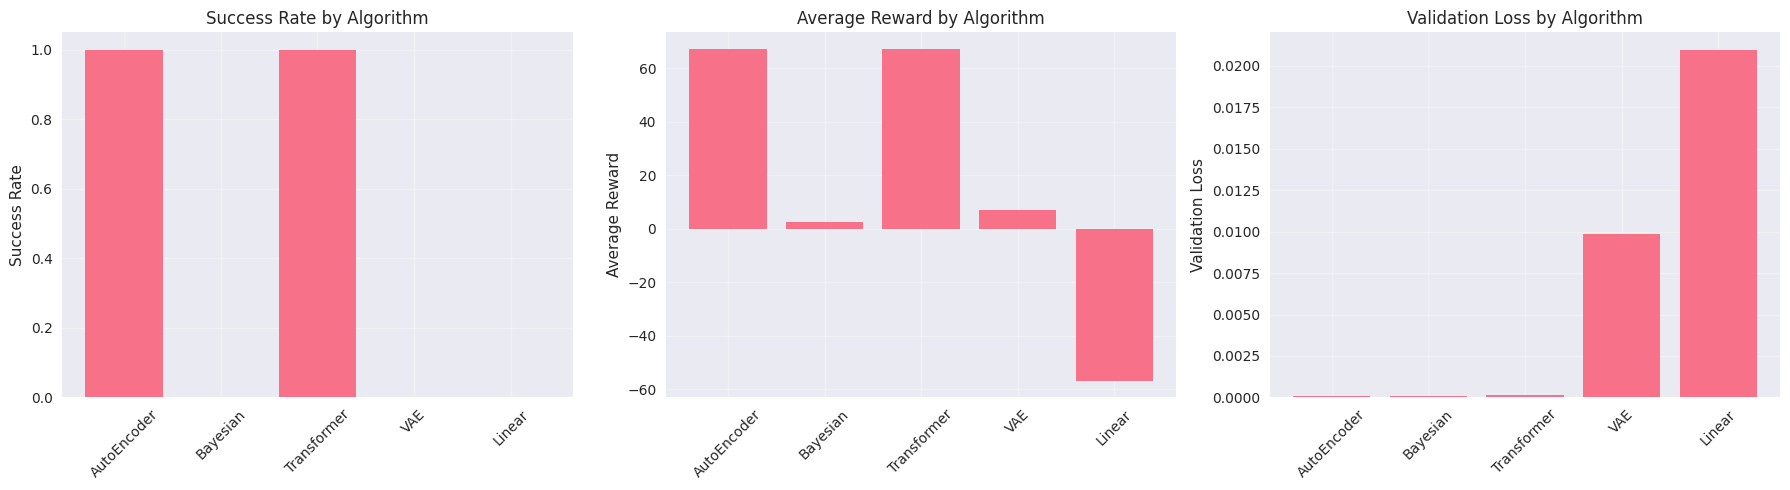

In [15]:
# Create comprehensive results table
import pandas as pd

results_data = []
for algo_name in all_results.keys():
    train_res = all_results[algo_name]
    eval_res = eval_results[algo_name]
    
    results_data.append({
        'Algorithm': algo_name,
        'Train Loss': train_res['train_losses'][-1],
        'Val Loss': train_res['val_losses'][-1],
        'Train Time (s)': train_res['train_time'],
        'Avg Reward': eval_res['avg_reward'],
        'Success Rate': eval_res['success_rate'],
        'Avg Steps': eval_res['avg_steps']
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values('Val Loss')

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Success Rate
axes[0].bar(df_results['Algorithm'], df_results['Success Rate'])
axes[0].set_ylabel('Success Rate')
axes[0].set_title('Success Rate by Algorithm')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Average Reward
axes[1].bar(df_results['Algorithm'], df_results['Avg Reward'])
axes[1].set_ylabel('Average Reward')
axes[1].set_title('Average Reward by Algorithm')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Validation Loss
axes[2].bar(df_results['Algorithm'], df_results['Val Loss'])
axes[2].set_ylabel('Validation Loss')
axes[2].set_title('Validation Loss by Algorithm')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
print("="*60)
print("DEBUGGING: Action and State Analysis")
print("="*60)

agent = all_results['Linear']['agent']
state = env.reset()
goal = env.goal.copy()

print(f"\nInitial State: {state}")
print(f"Goal Position: {goal}")
print(f"Distance to Goal: {np.linalg.norm(state[:2] - goal):.3f}")
print(f"\nAction Space: [{env.action_space.low}, {env.action_space.high}]")

print(f"\n{'Step':<6} {'Action':<20} {'State[:2]':<20} {'Distance':<10} {'Reward':<8}")
print("-" * 70)

for step in range(5):
    state_t = torch.tensor(state, dtype=torch.float32, device=CONFIG['device'])
    action = agent.predict_action(state_t, None)
    
    if isinstance(action, torch.Tensor):
        action = action.cpu().numpy()
    
    next_state, reward, done, info = env.step(action)
    distance = np.linalg.norm(next_state[:2] - goal)
    
    print(f"{step:<6} {str(action):<20} {str(next_state[:2]):<20} {distance:<10.3f} {reward:<8.3f}")
    
    state = next_state
    if done:
        print(f"\nEpisode ended: {info.get('reason', 'unknown')}")
        break

print(f"\n{'='*60}")
print("Training Data Statistics:")
print(f"{'='*60}")
print(f"Expert actions - Mean: {actions.mean(axis=0)}")
print(f"Expert actions - Std:  {actions.std(axis=0)}")
print(f"Expert actions - Min:  {actions.min(axis=0)}")
print(f"Expert actions - Max:  {actions.max(axis=0)}")


DEBUGGING: Action and State Analysis

Initial State: [ 1.         1.         0.7853982  0.4067763  4.         4.
 -1.        -0.       ]
Goal Position: [5. 5.]
Distance to Goal: 5.657

Action Space: [[ 0.        -0.5235988], [2.        0.5235988]]

Step   Action               State[:2]            Distance   Reward  
----------------------------------------------------------------------
0      [ 2.0954838  -0.10829221] [1.0362204 1.0354444] 5.606      0.020   
1      [ 2.1292045  -0.12264539] [1.0801053 1.0773478] 5.546      0.020   
2      [ 2.1444194  -0.10601441] [1.1317372 1.1256124] 5.475      0.021   
3      [ 2.1560962  -0.09028953] [1.1911695 1.1801715] 5.394      0.021   
4      [ 2.1642423  -0.07546795] [1.2584292 1.2409873] 5.304      0.021   

Training Data Statistics:
Expert actions - Mean: [ 0.63308294 -0.39905053]
Expert actions - Std:  [0.61646185 0.21801664]
Expert actions - Min:  [ 0.         -0.52359879]
Expert actions - Max:  [2. 0.]
